# CenterSnap: Single-Shot Multi-Object 3D Shape Reconstruction and Categorical 6D Pose and Size Estimation
    
<img src="https://raw.githubusercontent.com/zubair-irshad/CenterSnap/master/demo/method.gif" width=100% height=auto>

<center>
    





### CenterSnap Exploration

This is a colab to explore CenterSnap inference properties, proposed in our work [Single-Shot Multi-Object 3D Shape Reconstruction and Categorical 6D Pose and Size Estimation](https://zubair-irshad.github.io/projects/CenterSnap.html).
#### Make sure that you have enabled the GPU under Runtime-> Change runtime type!

We will perform inference using the learnt model and then visualize qualitative results!



In [1]:
# Clone the CenterSnap repository from GitHub to the current working directory in Colab.
!git clone https://github.com/francis-j-k/CenterSnap_Implimentation.git

# Upgrade pip to the latest version to ensure compatibility with any package requirements.
!pip install --upgrade pip

# Change the current working directory to the cloned 'CenterSnap' directory.
# Install all the dependencies listed in the 'requirements.txt' file of the CenterSnap project.
!cd CenterSnap_Implimentation && pip install -r requirements.txt

# Install specific versions of PyTorch and torchvision that are compatible with CUDA 10.1.
# This step ensures that you have the correct PyTorch setup for GPU acceleration provided by Colab's CUDA environment.
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# Change directory to 'CenterSnap', download a compressed file (nocs_test_subset.tar.gz) containing the NOCS dataset subset from Dropbox.
# The `-O` option specifies the output filename, and `tar -xzvf` command is used to extract the tar.gz file.
!cd CenterSnap_Implimentation && wget https://www.dropbox.com/s/yfenvre5fhx3oda/nocs_test_subset.tar.gz?dl=1 -O nocs_test_subset.tar.gz && tar -xzvf nocs_test_subset.tar.gz


fatal: destination path 'CenterSnap_Implimentation' already exists and is not an empty directory.
  Using cached absl_py-0.13.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached boto3-1.18.1-py3-none-any.whl.metadata (6.0 kB)
  Using cached botocore-1.21.1-py3-none-any.whl.metadata (5.5 kB)
  Using cached cachetools-4.2.2-py3-none-any.whl.metadata (4.6 kB)
  Using cached certifi-2021.5.30-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-2.0.3-py3-none-any.whl.metadata (11 kB)
  Using cached click-8.0.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached configparser-5.0.2-py3-none-any.whl.metadata (10 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl.metadata (722 bytes)
  Using cached future-0.18.2.tar.gz (829 kB)
  Preparing metadata (setup.py) ... done
  Using cached gitdb-4.0.7-py3-none-any.whl.metadata (998 bytes)
  Using cached GitPython-3.1.18-py3-none-any.whl.metadata (1.1 kB)
  Using cached google_auth-1.33.0-py2.py3-none-any.whl.metadata (3.5 kB)
  U

In [2]:
# Install the 'wandb' library to enable experiment tracking, which is useful for monitoring model training processes.
!pip install wandb

# Install 'fvcore', a library by Facebook that includes common core library functions and classes helpful in building computer vision systems.
!pip install fvcore

# Install 'open3d' for processing 3D data, which is particularly useful for tasks involving point clouds, meshes, and visualization.
!pip install open3d

# Install 'pytorch-lightning' to simplify the training of PyTorch models. It helps organize the code and reduces the boilerplate code.
!pip install pytorch-lightning

# Install 'shortuuid' to generate shorter, unique identifiers, commonly used for creating concise, unambiguous, URL-safe UUIDs.
!pip install shortuuid

# Install 'boto3', the Amazon Web Services (AWS) SDK for Python, which allows Python developers to write software that uses services like Amazon S3 and Amazon EC2.
!pip install boto3

# Install 'zstandard', a fast compression library providing high compression ratios. It is used to compress and decompress large volumes of data efficiently.
!pip install zstandard

# Install 'numpy', a fundamental package for scientific computing with Python, widely used for data manipulation and analysis.
!pip install numpy


In [4]:
# Importing essential libraries for command line arguments, path operations, and system interactions.
import argparse
import pathlib
import os
import sys
sys.path.append('CenterSnap_Implimentation')  # Include CenterSnap directory for module access.

# Importing core scientific computing and image processing libraries.
import cv2  # OpenCV for image processing.
import numpy as np  # NumPy for numerical operations.
import open3d as o3d  # Open3D for 3D data processing.
import matplotlib.pyplot as plt  # Matplotlib for plotting graphs.

# Importing PyTorch and related libraries for deep learning tasks.
import torch
import torch.nn.functional as F
import pytorch_lightning as pl  # PyTorch Lightning simplifies training workflows.

# Importing utilities for serialization and timing.
import _pickle as cPickle
import time

# Importing specific modules from the CenterSnap project for 3D vision tasks.
from simnet.lib.net import common
from simnet.lib import camera
from simnet.lib.net.panoptic_trainer import PanopticModel
from simnet.lib.net.models.auto_encoder import PointCloudAE
from utils.nocs_utils import load_img_NOCS, create_input_norm
from utils.viz_utils import depth2inv, viz_inv_depth
from utils.transform_utils import get_gt_pointclouds, transform_coordinates_3d, calculate_2d_projections, project
from utils.viz_utils import save_projected_points, draw_bboxes, line_set_mesh, display_gird, draw_geometries, show_projected_points


## 1. Instantiate CenterSnap Model

In [7]:
# Set command line arguments to include configuration from a file.
sys.argv = ['', '@CenterSnap_Implimentation/configs/net_config.txt']

# Setup argparse to enable reading arguments from a prefix file.
parser = argparse.ArgumentParser(fromfile_prefix_chars='@')

# Add training arguments from a common utility module.
common.add_train_args(parser)

# Create a specific argument group for application-related settings.
app_group = parser.add_argument_group('app')

# Adding application specific arguments with defaults.
app_group.add_argument('--app_output', default='inference', type=str)
app_group.add_argument('--result_name', default='centersnap_nocs', type=str)
app_group.add_argument('--data_dir', default='CenterSnap_Implimentation/nocs_test_subset', type=str)

# Parse the arguments passed to the script.
hparams = parser.parse_args()

# Set a minimum confidence level for processing.
min_confidence = 0.50

# Flag to determine if the GPU should be used.
use_gpu = True

# Specify the path to the checkpoint file for the model.
hparams.checkpoint = 'CenterSnap_Implimentation/nocs_test_subset/checkpoint/centersnap_real.ckpt'

# Initialize the PanopticModel with hyperparameters.
model = PanopticModel(hparams, 0, None, None)

# Set the model to evaluation mode.
model.eval()

# Move the model to GPU if use_gpu is set to True.
if use_gpu:
    model.cuda()

# Load data paths from a file within the specified data directory.
data_path = open(os.path.join(hparams.data_dir, 'Real', 'test_list_subset.txt')).read().splitlines()

# Initialize the camera settings specific to the NOCS Real dataset.
_CAMERA = camera.NOCS_Real()


Using model class from: /content/CenterSnap_Implimentation/simnet/lib/net/models/panoptic_net.py
Restoring from checkpoint: CenterSnap_Implimentation/nocs_test_subset/checkpoint/centersnap_real.ckpt


In [8]:
def get_auto_encoder(model_path):
    # Set the embedding dimension and number of points for the point cloud autoencoder.
    emb_dim = 128
    n_pts = 2048

    # Initialize the PointCloudAE model with the specified dimensions.
    ae = PointCloudAE(emb_dim, n_pts)

    # Move the model to GPU to enable CUDA acceleration.
    ae.cuda()

    # Load the pre-trained model weights from the specified path.
    ae.load_state_dict(torch.load(model_path))

    # Set the model to evaluation mode to disable dropout and batch normalization during inference.
    ae.eval()

    # Return the initialized and loaded model.
    return ae


## 2. Perform inference using NOCS Real Subset

In [10]:
# Setting a specific index to select a subset of the data.
num = 0

# Construct the full path to the specific image data.
img_full_path = "CenterSnap_Implimentation/nocs_test_subset/Real/test/scene_3/0238"
print("path", img_full_path)

# Load the color image from the specified path.
img_vis = cv2.imread(img_full_path + '_color.png')

# Load RGB image, depth image from NOCS dataset and process them.
left_linear, depth, actual_depth = load_img_NOCS(img_full_path + '_color.png', img_full_path + '_depth.png')

# Normalize the input data and add a batch dimension.
input = create_input_norm(left_linear, depth)[None, :, :, :]

# Define the path to the autoencoder model's checkpoint.
auto_encoder_path = os.path.join(hparams.data_dir, 'ae_checkpoints', 'model_50_nocs.pth')

# Load the autoencoder model using the defined path.
ae = get_auto_encoder(auto_encoder_path)

# If a GPU is available and specified for use, transfer the input to GPU.
if use_gpu:
    input = input.to(torch.device('cuda:0'))

# Perform forward pass with the model to obtain pose outputs.
_, _, _, pose_output = model.forward(input)

# Using no_grad to prevent tracking history in autograd during inference (saves memory and computations).
with torch.no_grad():
    # Compute point clouds and poses from the model's output considering the minimum confidence threshold.
    latent_emb_outputs, abs_pose_outputs, peak_output, _, _ = pose_output.compute_pointclouds_and_poses(min_confidence, is_target=False)


path CenterSnap_Implimentation/nocs_test_subset/Real/test/scene_3/0238


### 2.1 Visualize Peaks output and Depth output

(480, 640, 3)


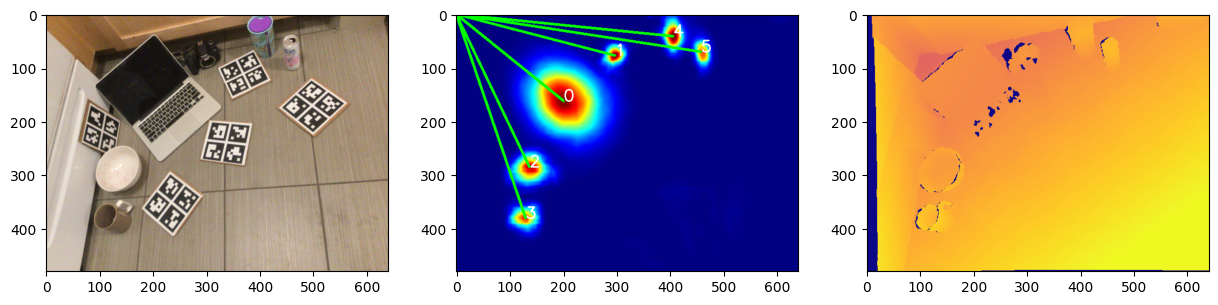

In [14]:
# The function display_gird is called with the color image, depth image, and peak output.
# This function is expected to visualize the given images and data, possibly in a grid format.

display_gird(img_vis, depth, peak_output)


## 2.2 Decode shape from latent embeddings

In [15]:
# Flag for saving point cloud data to disk (not used in the current snippet).
write_pcd = False

# Lists to hold various outputs and visual representations.
rotated_pcds = []
points_2d = []
box_obb = []
axes = []
colors_array = []
boxes = []

# Iterate over the latent embeddings outputs.
for j in range(len(latent_emb_outputs)):
    # Extract the embedding and ensure it's a PyTorch tensor.
    emb = torch.FloatTensor(latent_emb_outputs[j]).unsqueeze(0).cuda()

    # Pass the embedding through the autoencoder to get the shape output.
    _, shape_out = ae(None, emb)
    shape_out = shape_out.cpu().detach().numpy()[0]

    # Generate ground truth point clouds and bounding boxes based on absolute pose outputs.
    rotated_pc, rotated_box, _ = get_gt_pointclouds(abs_pose_outputs[j], shape_out, camera_model=_CAMERA)

    # Create a point cloud object and append to list.
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(rotated_pc)
    rotated_pcds.append(pcd)

    # Apply uniform color to the point cloud and store the color.
    pcd.paint_uniform_color((1.0, 0.0, 0.0))
    colors_array.append(pcd.colors)

    # Create a coordinate frame mesh for reference in the scene.
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
    T = abs_pose_outputs[j].camera_T_object
    mesh_frame = mesh_frame.transform(T)
    rotated_pcds.append(mesh_frame)

    # Generate cylinder segments from bounding boxes for visualization.
    cylinder_segments = line_set_mesh(rotated_box)
    for k in cylinder_segments:
        rotated_pcds.append(k)

    # Project the 3D points to 2D for visualization purposes.
    points_mesh = camera.convert_points_to_homopoints(rotated_pc.T)
    points_2d_mesh = project(_CAMERA.K_matrix, points_mesh).T
    points_2d.append(points_2d_mesh)

    # Convert bounding box points for 2D projection.
    points_obb = camera.convert_points_to_homopoints(np.array(rotated_box).T)
    points_2d_obb = project(_CAMERA.K_matrix, points_obb).T
    box_obb.append(points_2d_obb)

    # Project transformation axes to 2D.
    xyz_axis = 0.3 * np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]).transpose()
    sRT = abs_pose_outputs[j].camera_T_object @ abs_pose_outputs[j].scale_matrix
    transformed_axes = transform_coordinates_3d(xyz_axis, sRT)
    projected_axes = calculate_2d_projections(transformed_axes, _CAMERA.K_matrix[:3, :3])
    axes.append(projected_axes)

# Draw all geometries collected in the rotated_pcds list.
draw_geometries(rotated_pcds)


## 2.3 Project 3D Pointclouds and 3D bounding boxes on 2D image

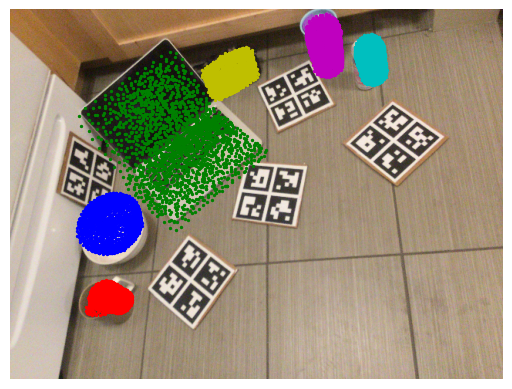

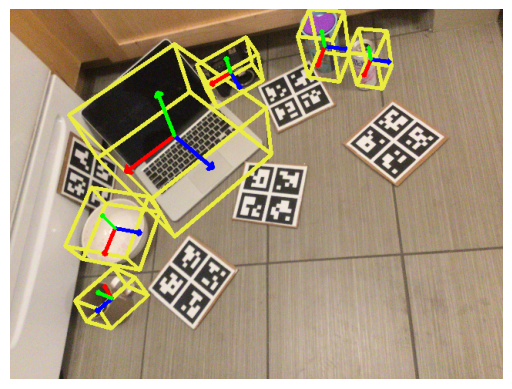

In [16]:
# Create a copy of the original color image to work with it without altering the original data.
color_img = np.copy(img_vis)

# Call the function 'show_projected_points' to overlay 2D projections of 3D points on the color image.
projected_points_img = show_projected_points(color_img, points_2d)

# Define a list with colors for bounding boxes as BGR tuples.
colors_box = [(63, 237, 234)]  # Cyan-like color

# Create another copy of the original image for drawing bounding boxes.
im = np.array(np.copy(img_vis)).copy()

# Loop over each set of 2D bounding box points and their corresponding axes.
for k in range(len(colors_box)):
    for points_2d, axis in zip(box_obb, axes):
        points_2d = np.array(points_2d)  # Ensure the points are in NumPy array format.

        # Draw bounding boxes on the image using the specified color and 2D points.
        im = draw_bboxes(im, points_2d, axis, colors_box[k])

# Invert the y-axis to correct the display orientation in matplotlib.
plt.gca().invert_yaxis()

# Turn off axis numbering and ticks.
plt.axis('off')

# Display the image using matplotlib, convert color space from BGR to RGB.
plt.imshow(im[..., ::-1])

# Show the plot.
plt.show()
